## Unsupervised Learning

Content Include: 
- 1. Clustering
  - The goal is to group similar instances together into clusters. 

- 2. Anomaly detection
  - The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

- 3. Density estimation
  - This is the task of estimating the probability density function (PDF) of the random process that generated the dataset. 
  - Density estimation is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.

### 2. Anomaly Detection Using Gaussian Mixtures

- Anomaly detection (also called outlier detection) is the task of detecting instances that deviate strongly from the norm.
- Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly.

This repo is my learning notebook following:

- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.

#### 2.1. Gaussian Mixtures

In [111]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

X1, y1 = make_blobs(n_samples=300, centers=((2, -2), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=100, centers=1, random_state=42)
X2 = X2 + [10, -9]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

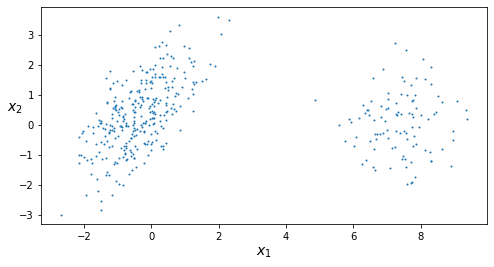

In [112]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [113]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=2, n_init=10, random_state=42)

In [114]:
gm.means_

array([[-0.37393143,  0.33203488],
       [ 7.37384885,  0.05529894]])

In [115]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

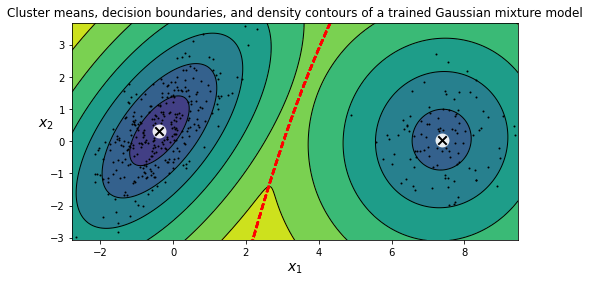

In [120]:
plt.figure(figsize=(8, 4))
plt.title("Cluster means, decision boundaries, and density contours of a trained Gaussian mixture model")
plot_gaussian_mixture(gm, X)

#save_fig("gaussian_mixtures_plot")
plt.show()

#### 2.2. Anomaly Detection

Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly.

Identify the outliers using the fourth percentile lowest density as the threshold (i.e., approximately 0.5% of the instances will be flagged as anomalies)

In [122]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 0.5)
anomalies = X[densities < density_threshold]

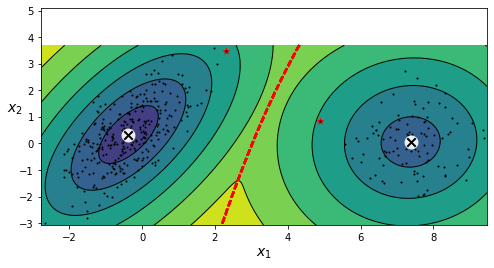

In [123]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

#save_fig("mixture_anomaly_detection_plot")
plt.show()

In [124]:
anomalies

array([[2.29682729, 3.49722873],
       [4.87105727, 0.83618863]])

#### 2.3. Select the most optimal cluster

In [ ]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [140]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

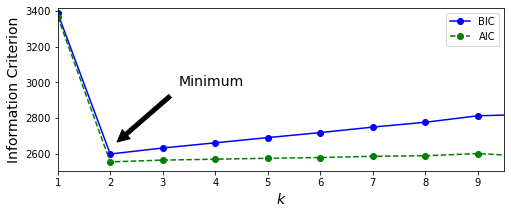

In [129]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(2, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
#save_fig("aic_bic_vs_k_plot")
plt.show()


Let's search for best combination of values for both the number of clusters and the covariance_type hyperparameter:

In [144]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [145]:
best_k

2